# Ковариация и корреляция

In [1]:
import requests                  # [handles the http interactions](http://docs.python-requests.org/en/master/) 
from bs4 import BeautifulSoup    # beautiful soup handles the html to text conversion and more
import re                        # regular expressions are necessary for finding the crumb (more on crumbs later)
from datetime import datetime    # string to datetime object conversion
from time import mktime          # mktime transforms datetime objects to unix timestamps
import pandas as pd 
import matplotlib.pyplot as plt
from string import ascii_letters
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# by https://maikros.github.io/yahoo-finance-python/

def _get_crumbs_and_cookies(stock):
    """
    get crumb and cookies for historical data csv download from yahoo finance
    
    parameters: stock - short-handle identifier of the company 
    
    returns a tuple of header, crumb and cookie
    """
    
    url = 'https://finance.yahoo.com/quote/{}/history'.format(stock)
    with requests.session():
        header = {'Connection': 'keep-alive',
                   'Expires': '-1',
                   'Upgrade-Insecure-Requests': '1',
                   'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) \
                   AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.99 Safari/537.36'
                   }
        
        website = requests.get(url, headers=header, verify=False) ### verify=False depends of HW
        soup = BeautifulSoup(website.text, 'lxml')
        crumb = re.findall('"CrumbStore":{"crumb":"(.+?)"}', str(soup))

        return (header, crumb[0], website.cookies)

In [3]:
def convert_to_unix(date):
    """
    converts date to unix timestamp
    
    parameters: date - in format (dd-mm-yyyy)
    
    returns integer unix timestamp
    """
    datum = datetime.strptime(date, '%d-%m-%Y')
    
    return int(mktime(datum.timetuple()))

In [4]:
def load_csv_data(stock, interval='1d', day_begin='01-03-2018', day_end='28-03-2018'):
    """
    queries yahoo finance api to receive historical data in csv file format
    
    parameters: 
        stock - short-handle identifier of the company
        
        interval - 1d, 1wk, 1mo - daily, weekly monthly data
        
        day_begin - starting date for the historical data (format: dd-mm-yyyy)
        
        day_end - final date of the data (format: dd-mm-yyyy)
    
    returns a list of comma seperated value lines
    """
    day_begin_unix = convert_to_unix(day_begin)
    day_end_unix = convert_to_unix(day_end)
    
    header, crumb, cookies = _get_crumbs_and_cookies(stock)
    
    with requests.session():
            url = 'https://query1.finance.yahoo.com/v7/finance/download/' \
                  '{stock}?period1={day_begin}&period2={day_end}&interval={interval}&events=history&crumb={crumb}' \
                  .format(stock=stock, day_begin=day_begin_unix, day_end=day_end_unix, interval=interval, crumb=crumb)

            website = requests.get(url, headers=header, cookies=cookies, verify=False) ### verify=False depends of HW

            parse = website.text.split('\n')[:-1]
    
    return np.array(list(map(lambda x: x.split(','), parse))), parse[0].split(',')
          
    

In [5]:
"""tickers = [ "AAPL", "AMD", "AMZN", "ATVI", "BA", "DIS", "FB", "GOOG",  "INTC", "MA",
            "MCD", "MSFT", "MU", "NFLX", "NVDA", "PFE", "T",  "TWTR", "V",   "XOM",
            "WMT", "GM", "DAL", "AVGO", "UNH", "CSCO", "CAT", "BIIB"]"""


tickers = ["GOOG","BA",  "INTC", "MU", "PFE"]
portfolio = pd.DataFrame()
for ticker in tickers:
    values, columns = load_csv_data(ticker,
                                    interval='1d', 
                                    day_begin='01-03-2018', 
                                    day_end='29-08-2022')
    portfolio[ticker] = pd.DataFrame(values[1:], columns = columns)['Adj Close']
portfolio.index = pd.DataFrame(values[1:], columns = columns)['Date']
portfolio = portfolio.astype('float')
portfolio.head()#.dtypes  

,GOOG,BA,INTC,MU,PFE
Date,,,,,
2018-02-28,55.236500,346.887451,43.786282,48.528492,29.233639
2018-03-01,53.476002,334.897095,42.498188,47.345356,28.686167
2018-03-02,53.945999,330.089539,43.510887,48.826763,28.943796
2018-03-05,54.546501,337.827667,44.194916,51.729919,29.080667
2018-03-06,54.752998,334.159698,45.047722,53.430061,28.887438


In [6]:
portfolio.shape

(1132, 5)

In [7]:
portfolio.dtypes

GOOG    float64
BA      float64
INTC    float64
MU      float64
PFE     float64
dtype: object

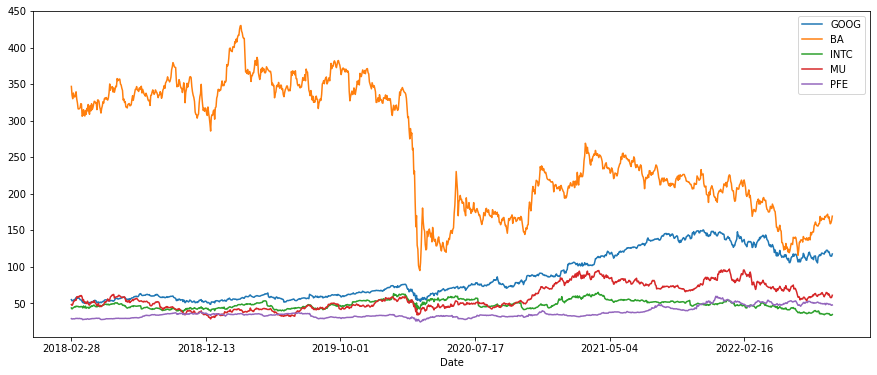

In [8]:
portfolio.plot(figsize=(15,6))
plt.show()

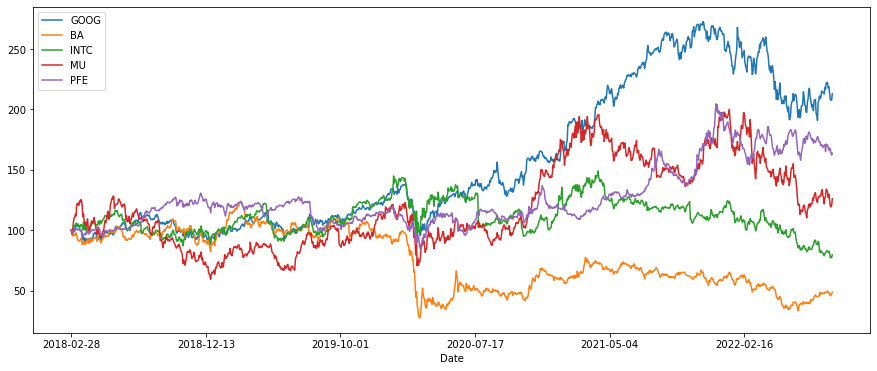

In [9]:
(portfolio / portfolio.iloc[0] * 100).plot(figsize = (15, 6));
plt.show()

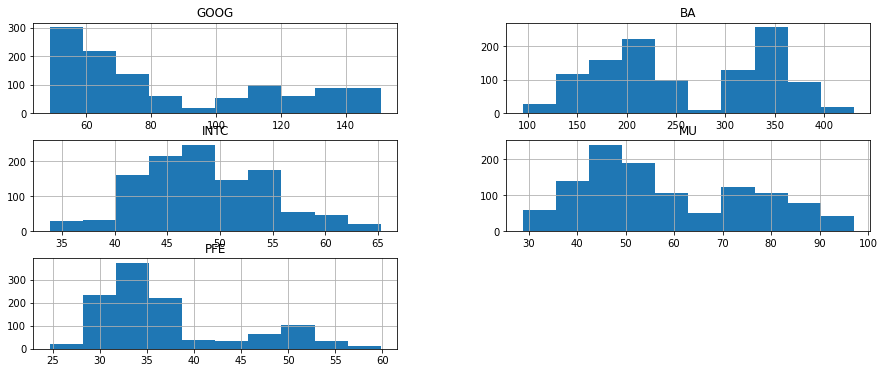

In [10]:
portfolio.hist(figsize=(15,6))
plt.show()

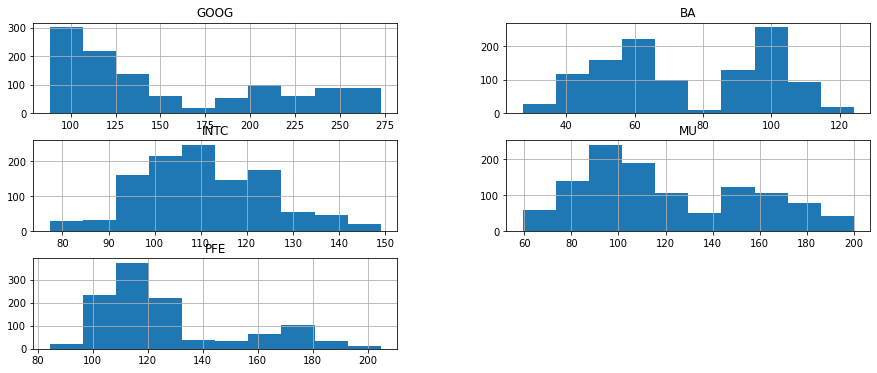

In [11]:
(portfolio / portfolio.iloc[0] * 100).hist(figsize = (15, 6));

In [12]:
returns = (portfolio / portfolio.shift(1)) - 1  # 0+/-
returns.tail()

,GOOG,BA,INTC,MU,PFE
Date,,,,,
2022-08-19,-0.022671,-0.034205,-0.022652,-0.039219,0.011733
2022-08-22,-0.025821,-0.024184,-0.043527,-0.036358,-0.005086
2022-08-23,-0.002607,0.006856,0.003251,-0.007717,-0.018200
2022-08-24,-0.000610,0.022053,-0.002651,0.007777,-0.012081
2022-08-25,0.026155,0.035330,0.030419,0.049563,0.009909


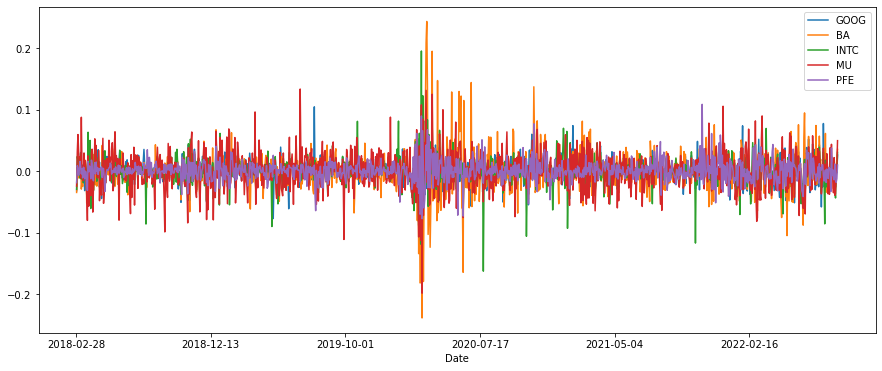

In [13]:
returns.plot(figsize = (15, 6));

In [14]:
annual_returns = returns.mean() * portfolio.shape[0] # mean in period
annual_returns

GOOG    0.967592
BA     -0.113196
INTC    0.091580
MU      0.755247
PFE     0.649189
dtype: float64

In [15]:
cov_matrix_a = returns.cov() * portfolio.shape[0]
cov_matrix_a

,GOOG,BA,INTC,MU,PFE
GOOG,0.420775,0.313959,0.288702,0.368105,0.117336
BA,0.313959,1.207932,0.378264,0.516725,0.165336
INTC,0.288702,0.378264,0.631770,0.517522,0.141477
MU,0.368105,0.516725,0.517522,1.041920,0.133539
PFE,0.117336,0.165336,0.141477,0.133539,0.310801


In [16]:
cov_matrix_LOG = np.log(portfolio / portfolio.shift(1)).cov() * portfolio.shape[0]
cov_matrix_LOG

,GOOG,BA,INTC,MU,PFE
GOOG,0.420657,0.322550,0.290713,0.372338,0.118047
BA,0.322550,1.213392,0.392291,0.531587,0.170462
INTC,0.290713,0.392291,0.642519,0.525079,0.141829
MU,0.372338,0.531587,0.525079,1.050280,0.136457
PFE,0.118047,0.170462,0.141829,0.136457,0.309589


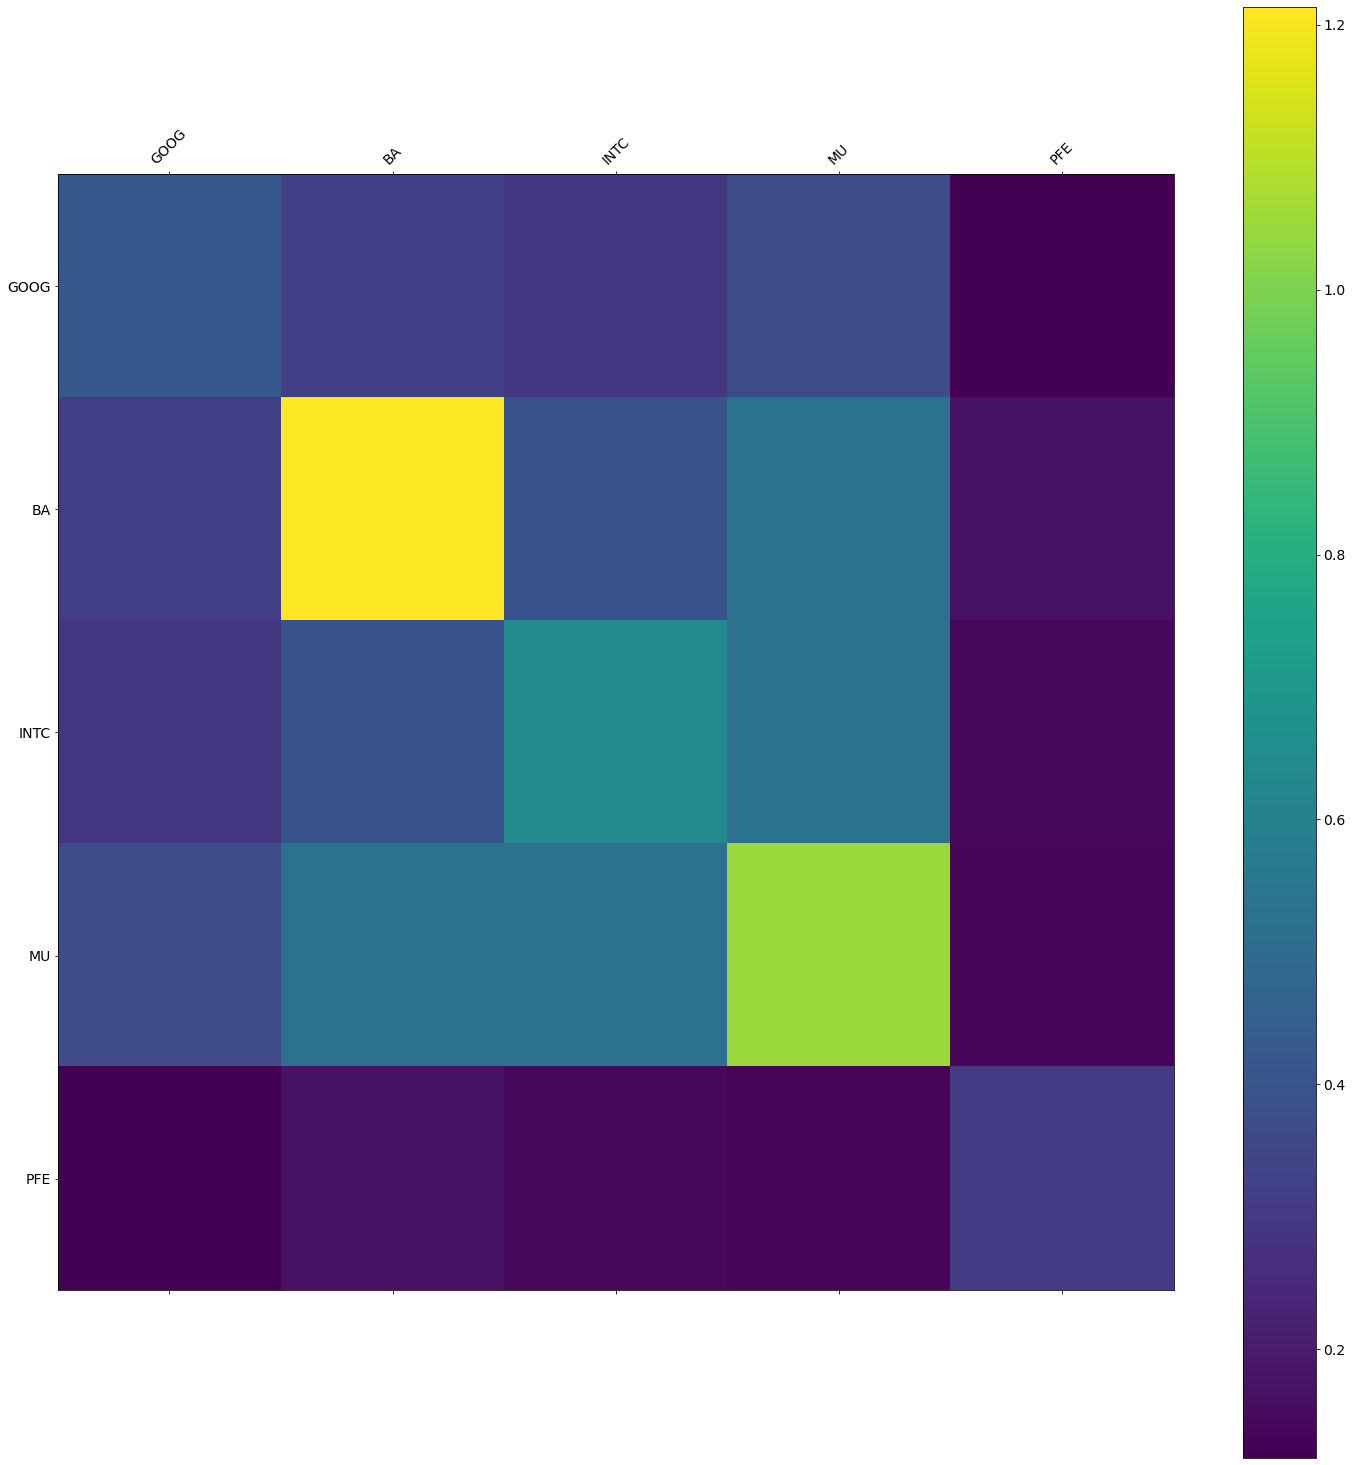

In [17]:
plt.figure(figsize=(25, 26))
plt.matshow(cov_matrix_LOG, fignum=1) #annot=True
plt.xticks(range(cov_matrix_LOG.shape[1]), cov_matrix_LOG.columns, fontsize=14, rotation=45)
plt.yticks(range(cov_matrix_LOG.shape[1]), cov_matrix_LOG.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

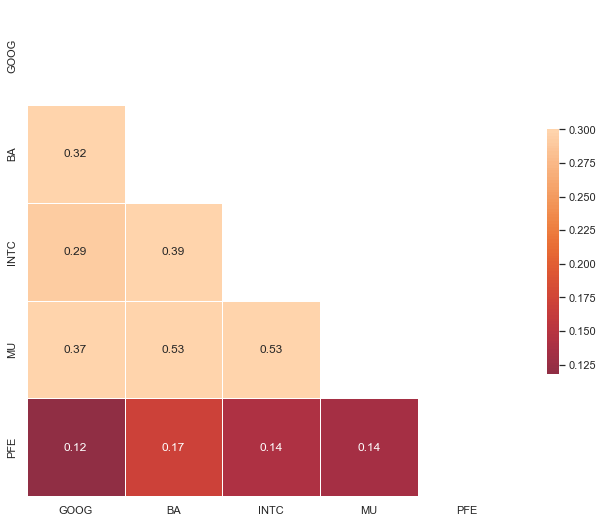

In [18]:
sns.set(style="whitegrid")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cov_matrix_LOG, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cov_matrix_LOG, mask=mask,  vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True,);

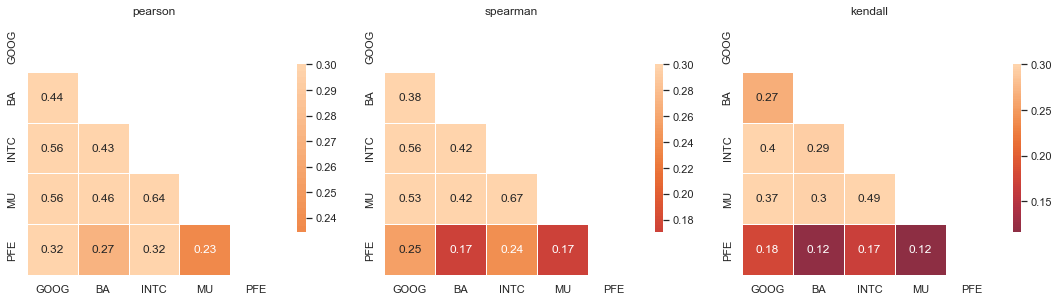

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
sns.set(style="whitegrid")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cov_matrix_a, dtype=np.bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)

for corr_type, ax in zip(('pearson', "spearman", 'kendall'),(ax1, ax2, ax3)):

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(returns.corr(method=corr_type), mask=mask,  vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, ax=ax)
    ax.set_title(corr_type)

plt.tight_layout()
plt.show();

In [20]:
## For Dimensionality Reduction
correlations = np.abs([np.corrcoef(portfolio["GOOG"],portfolio[col_name])[0,1] for col_name in tickers[1:]])
print (list(zip(tickers[1:],correlations)))

[('BA', 0.597603595808259), ('INTC', 0.1951467449720233), ('MU', 0.8482160685345834), ('PFE', 0.7952881835673913)]


In [21]:
correlations[correlations < .8]

array([0.5976036 , 0.19514674, 0.79528818])

In [22]:
returns.isna().count()

GOOG    1132
BA      1132
INTC    1132
MU      1132
PFE     1132
dtype: int64

In [23]:
returns.dropna(inplace = True) 
returns

,GOOG,BA,INTC,MU,PFE
Date,,,,,
2018-03-01,-0.031872,-0.034566,-0.029418,-0.024380,-0.018727
2018-03-02,0.008789,-0.014355,0.023829,0.031289,0.008981
2018-03-05,0.011132,0.023443,0.015721,0.059458,0.004729
2018-03-06,0.003786,-0.010858,0.019296,0.032866,-0.006645
2018-03-07,0.013314,-0.005388,0.012029,0.004280,0.001394
...,...,...,...,...,...
2022-08-19,-0.022671,-0.034205,-0.022652,-0.039219,0.011733
2022-08-22,-0.025821,-0.024184,-0.043527,-0.036358,-0.005086
2022-08-23,-0.002607,0.006856,0.003251,-0.007717,-0.018200


In [24]:
sem = pd.DataFrame(columns = ('pearson', "spearman", 'kendall'))
for corr_type in sem.columns:
    print (corr_type)
    sem[corr_type] = [returns['GOOG'].corr(other=returns["BA"], method=corr_type)] #.sem()
sem

pearson
spearman
kendall


,pearson,spearman,kendall
0,0.440379,0.382455,0.266933


In [25]:
[returns['GOOG'].corr(other=returns["BA"])]

[0.44037937745904004]

In [26]:
returns['GOOG'].sem() 

0.0005732847856744592

In [27]:
returns['GOOG'].mean() 

0.000854763366357369

<AxesSubplot:>

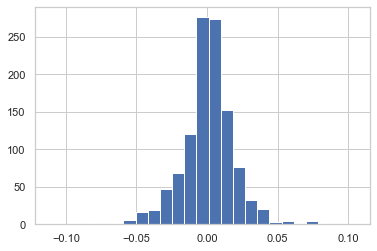

In [28]:
returns['GOOG'].hist(bins=25)